In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.mpradragonn_deconv_conv_generator_concat import load_generator_network, get_shallow_copy_function
from definitions.predictor.mpradragonn_deep_factorized_model import load_saved_predictor
#from definitions.predictor.mpradragonn_conv_model import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

def load_data(data_name, valid_set_size=0.05, test_set_size=0.05) :
    
    #Load cached dataframe
    cached_dict = pickle.load(open(data_name, 'rb'))
    x_train = cached_dict['x_train']
    y_train = cached_dict['y_train']
    x_test = cached_dict['x_test']
    y_test = cached_dict['y_test']

    g_nt = np.zeros((1, 1, 1, 4))
    g_nt[0, 0, 0, 2] = 1.

    x_train = np.concatenate([x_train, np.tile(g_nt, (x_train.shape[0], 1, 15, 1))], axis=2)
    x_test = np.concatenate([x_test, np.tile(g_nt, (x_test.shape[0], 1, 15, 1))], axis=2)
    
    return x_train, x_test

def load_predictor_model(model_path) :

    saved_model = Sequential()

    # sublayer 1
    saved_model.add(Conv1D(48, 3, padding='same', activation='relu', input_shape=(145, 4), name='dragonn_conv1d_1_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_1_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_1_copy'))

    saved_model.add(Conv1D(64, 3, padding='same', activation='relu', name='dragonn_conv1d_2_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_2_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_2_copy'))

    saved_model.add(Conv1D(100, 3, padding='same', activation='relu', name='dragonn_conv1d_3_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_3_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_3_copy'))

    saved_model.add(Conv1D(150, 7, padding='same', activation='relu', name='dragonn_conv1d_4_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_4_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_4_copy'))

    saved_model.add(Conv1D(300, 7, padding='same', activation='relu', name='dragonn_conv1d_5_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_5_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_5_copy'))

    saved_model.add(MaxPooling1D(3))

    # sublayer 2
    saved_model.add(Conv1D(200, 7, padding='same', activation='relu', name='dragonn_conv1d_6_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_6_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_6_copy'))

    saved_model.add(Conv1D(200, 3, padding='same', activation='relu', name='dragonn_conv1d_7_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_7_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_7_copy'))

    saved_model.add(Conv1D(200, 3, padding='same', activation='relu', name='dragonn_conv1d_8_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_8_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_8_copy'))

    saved_model.add(MaxPooling1D(4))

    # sublayer 3
    saved_model.add(Conv1D(200, 7, padding='same', activation='relu', name='dragonn_conv1d_9_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_9_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_9_copy'))

    saved_model.add(MaxPooling1D(4))

    saved_model.add(Flatten())
    saved_model.add(Dense(100, activation='relu', name='dragonn_dense_1_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_10_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_10_copy'))
    saved_model.add(Dense(12, activation='linear', name='dragonn_dense_2_copy'))

    saved_model.compile(
        loss= "mean_squared_error",
        optimizer=keras.optimizers.SGD(lr=0.1)
    )

    saved_model.load_weights(model_path)
    
    return saved_model

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:

class GenesisMonitor(Callback):
    def __init__(self, generator_model, sequence_encoder, run_dir="", run_prefix="", n_sequences=32, batch_size=32, input_tensor_funcs=None) :
        self.generator_model = generator_model
        self.batch_size = batch_size
        self.n_sequences = n_sequences
        self.input_tensor_funcs = input_tensor_funcs
        self.sequence_encoder = sequence_encoder
        self.run_prefix = run_prefix
        self.run_dir = run_dir
        
        if not os.path.exists(self.run_dir): os.makedirs(self.run_dir)

        seqs = self._sample_sequences()
        self._store_sequences(seqs, 0)
    
    def _sample_sequences(self) :
        n_batches = self.n_sequences // self.batch_size
        
        self.input_tensors = [self.input_tensor_funcs[i](i) for i in range(len(self.input_tensor_funcs))]
        gen_bundle = self.generator_model.predict(x=self.input_tensors, batch_size=self.batch_size)
        _, _, _, _, _, sampled_pwm, _, _, _ = gen_bundle
        
        seqs = [
            self.sequence_encoder.decode(sampled_pwm[i, 0, :, :, 0]) for i in range(sampled_pwm.shape[0])
        ]
        
        return seqs
    
    def _store_sequences(self, seqs, epoch) :
        #Save sequences to file
        with open(self.run_dir + self.run_prefix + "_epoch_" + str(epoch) + "_" + str(self.n_sequences) + "_sequences.txt", "wt") as f:
            for i in range(len(seqs)) :
                f.write(seqs[i] + "\n")
    
    def on_epoch_end(self, epoch, logs={}) :
        
        seqs = self._sample_sequences()
        self._store_sequences(seqs, epoch)


In [3]:

#Define margin activity loss function
def get_activity_loss(output_ix, fitness_target, fitness_weight=2., pwm_start=0, pwm_end=145, pwm_target_bits=1.8, vae_pwm_start=0, entropy_weight=0.0, entropy_loss_mode='margin', similarity_weight=0.0, similarity_margin=0.5) :
    
    masked_entropy_mse = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end, target_bits=pwm_target_bits)
    if entropy_loss_mode == 'margin' :
        masked_entropy_mse = get_margin_entropy_ame_masked(pwm_start=pwm_start, pwm_end=pwm_end, min_bits=pwm_target_bits)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=pwm_start, pwm_end=pwm_end, margin=similarity_margin, shift_1_nt=True)
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, score_pred = loss_tensors
        
        #Specify costs
        fitness_loss = fitness_weight * K.mean(K.maximum(-K.print_tensor(score_pred[..., output_ix], message="score_pred=") + fitness_target, K.zeros_like(score_pred[..., output_ix])), axis=1)
        
        entropy_loss = entropy_weight * masked_entropy_mse(pwm_1, mask)
        
        similarity_loss = similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)
        
        #Compute total loss
        total_loss = fitness_loss + entropy_loss + similarity_loss
        
        return total_loss
    
    return loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(run_prefix, sequence_templates, loss_func, model_path, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100, n_intermediate_sequences=960) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Validation Generator Network
    _, val_generator = get_generator_copier(generator)(batch_size, len(sequence_templates[0]), get_shallow_copy_function(generator), n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False, validation_sample_mode='sample', supply_inputs=True)
    
    #Build Predictor Network and hook it on the generator PWM output tensor
    _, predictor = build_predictor(generator, load_saved_predictor(model_path), batch_size, n_samples=n_samples, eval_mode='sample')

    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, loss_model = build_loss_model(predictor, loss_func)
    
    #Specify Optimizer to use
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    
    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)
    
    #Randomized validation tensors
    val_random_tensor_funcs = [
        lambda i: np.array(np.zeros(n_intermediate_sequences)).reshape(-1, 1),
        lambda i: np.random.uniform(-1, 1, (n_intermediate_sequences, 100)),
        lambda i: np.random.uniform(-1, 1, (n_intermediate_sequences, 100))
    ]

    #Standard sequence decoder
    acgt_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})
    
    #Build callback for printing intermediate sequences
    random_genesis_monitor = GenesisMonitor(val_generator, acgt_encoder, run_dir="./samples/" + run_prefix + "/", run_prefix="intermediate", n_sequences=n_intermediate_sequences, batch_size=batch_size, input_tensor_funcs=val_random_tensor_funcs)

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=[random_genesis_monitor]
    )
    
    train_history = None

    return generator, predictor, train_history


In [4]:
#Specfiy file path to pre-trained predictor network
saved_predictor_model_path = '../../../seqprop/examples/mpradragonn/pretrained_deep_factorized_model.hdf5'

In [5]:
#Maximize isoform proportions for all native minigene libraries

sequence_templates = [
    'N' * 145
]


In [6]:
#Train MPRA-DragoNN GENESIS Network

print("Training GENESIS")

model_prefix = "genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_03_earthmover_weight_01_target_35"

#Number of PWMs to generate per objective
batch_size = 64
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
#Number of epochs per objective to optimize
n_epochs = 250
#Number of steps (grad updates) per epoch
steps_per_epoch = 100

#Number of sequences to sample and store for each epoch
n_intermediate_sequences = 960

K.clear_session()

loss = get_activity_loss(
    5,
    3.5,
    fitness_weight=0.1,
    pwm_start=0,
    pwm_end=145,
    pwm_target_bits=1.8,
    entropy_weight=0.5,
    entropy_loss_mode='margin',
    similarity_weight=5.0,
    similarity_margin=0.3,
)

generator_model, predictor_model, train_history = run_genesis(model_prefix, [sequence_templates[0]], loss, saved_predictor_model_path, batch_size, n_samples, n_epochs, steps_per_epoch, n_intermediate_sequences)

generator_model.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
generator_model.get_layer('lambda_rand_input_1').function = lambda inp: inp
generator_model.get_layer('lambda_rand_input_2').function = lambda inp: inp

predictor_model.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
predictor_model.get_layer('lambda_rand_input_1').function = lambda inp: inp
predictor_model.get_layer('lambda_rand_input_2').function = lambda inp: inp

# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = model_prefix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)
generator_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = model_prefix + '_predictor.h5'
model_path = os.path.join(save_dir, model_name)
predictor_model.save(model_path)
print('Saved trained model at %s ' % model_path)


Training GENESIS
Epoch 1/250
100/100 [==============================] - 7s 74ms/step - loss: 1.1326
Epoch 2/250
100/100 [==============================] - 4s 44ms/step - loss: 0.4450
Epoch 3/250
100/100 [==============================] - 4s 44ms/step - loss: 0.2794
Epoch 4/250
100/100 [==============================] - 4s 44ms/step - loss: 0.2440
Epoch 5/250
100/100 [==============================] - 4s 44ms/step - loss: 0.2286
Epoch 6/250
100/100 [==============================] - 4s 44ms/step - loss: 0.2150
Epoch 7/250
100/100 [==============================] - 4s 44ms/step - loss: 0.2123
Epoch 8/250
100/100 [==============================] - 4s 44ms/step - loss: 0.2029
Epoch 9/250
100/100 [==============================] - 4s 44ms/step - loss: 0.2007
Epoch 10/250
100/100 [==============================] - 4s 44ms/step - loss: 0.2037
Epoch 11/250
100/100 [==============================] - 4s 44ms/step - loss: 0.1911
Epoch 12/250
100/100 [==============================] - 4s 44ms/step

100/100 [==============================] - 8s 80ms/step - loss: 0.1330
Epoch 195/250
100/100 [==============================] - 8s 80ms/step - loss: 0.1394
Epoch 196/250
100/100 [==============================] - 8s 80ms/step - loss: 0.1332
Epoch 197/250
100/100 [==============================] - 8s 79ms/step - loss: 0.1354
Epoch 198/250
100/100 [==============================] - 8s 79ms/step - loss: 0.1341
Epoch 199/250
100/100 [==============================] - 8s 80ms/step - loss: 0.1386
Epoch 200/250
100/100 [==============================] - 8s 80ms/step - loss: 0.1358
Epoch 201/250
100/100 [==============================] - 8s 80ms/step - loss: 0.1364
Epoch 202/250
100/100 [==============================] - 8s 80ms/step - loss: 0.1390
Epoch 203/250
100/100 [==============================] - 8s 80ms/step - loss: 0.1433
Epoch 204/250
100/100 [==============================] - 8s 80ms/step - loss: 0.1427
Epoch 205/250
100/100 [==============================] - 8s 79ms/step - loss: 0

In [7]:
#Specfiy file path to pre-trained predictor network

saved_predictor_model_path = '../../../seqprop/examples/mpradragonn/pretrained_deep_factorized_model.hdf5'

saved_predictor = load_predictor_model(saved_predictor_model_path)

acgt_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


score_pred = 2.4849217


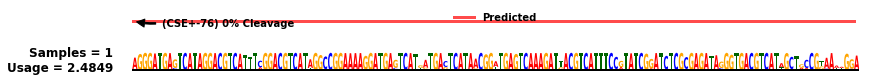

score_pred = 2.8833992


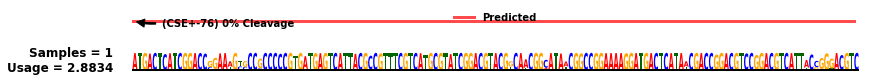

score_pred = 3.8073559


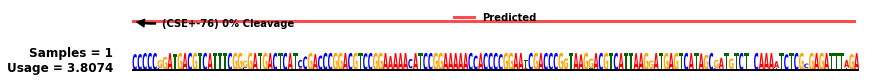

score_pred = 2.6366525


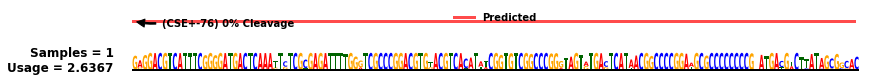

score_pred = 2.6763785


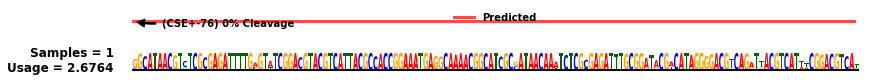

score_pred = 2.516525


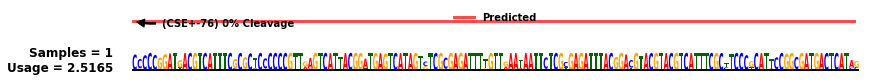

score_pred = 2.377424


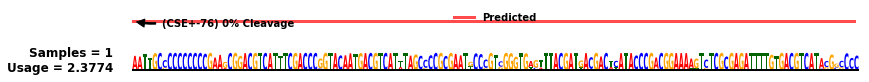

score_pred = 2.563277


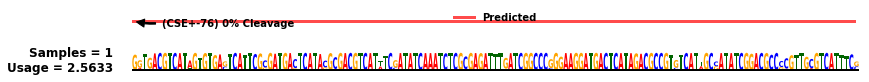

score_pred = 3.5001245


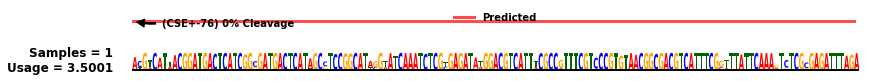

score_pred = 2.6012442


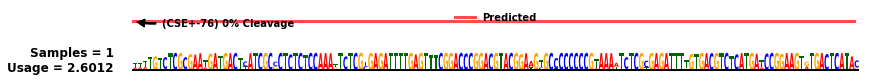

score_pred = 2.5157146


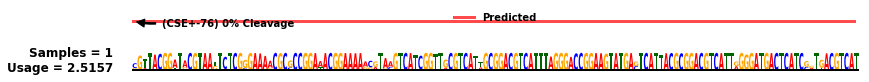

score_pred = 2.5688024


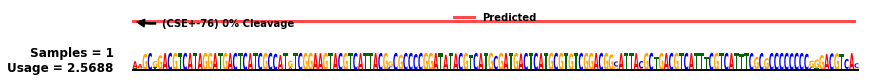

score_pred = 2.742023


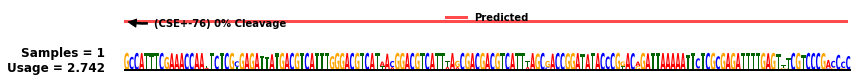

score_pred = 3.3787544


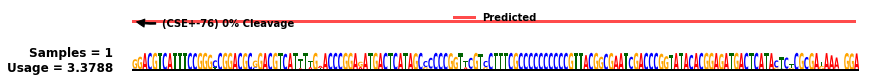

score_pred = 2.0878575


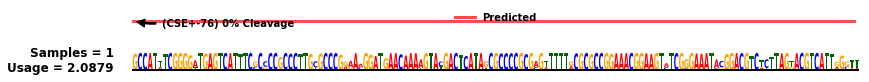

score_pred = 2.968775


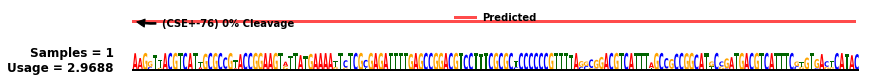

In [9]:
#Load GENESIS models and predict sample sequences

model_prefix = "genesis_mpradragonn_max_activity_sv40_25000_updates_similarity_margin_03_earthmover_weight_01_target_35"
batch_size = 64

sequence_template = sequence_templates[0]

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = model_prefix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)

generator = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

n = batch_size

sequence_class = np.array([0] * n).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = generator.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _ = pred_outputs

#Make predictions using black box model

score_pred = saved_predictor.predict(x=[sampled_pwm[:, 0, :, :, 0]], batch_size=batch_size)

for pwm_index in range(16) :

    print("score_pred = " + str(score_pred[pwm_index, 5]))
    
    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    cut = np.zeros((1, 145))
    sco = np.expand_dims(np.expand_dims(score_pred[pwm_index, 5], axis=0), axis=-1)

    plot_seqprop_logo(pwm, sco, cut, annotate_peaks='max', sequence_template=sequence_templates[0], figsize=(12, 1.25), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=145)


In [10]:
#Load GENESIS models and predict sample sequences

n = 1000
n_slack = 0.05 * n

n_ceil = int((n + n_slack) / batch_size) * batch_size + batch_size

sequence_class = np.array([0] * n_ceil).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.random.uniform(-1, 1, (n_ceil, 100))
noise_2 = np.random.uniform(-1, 1, (n_ceil, 100))

pred_outputs = generator.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _ = pred_outputs

pwms = optimized_pwm[:, :, :, 0]
onehots = sampled_pwm[:, 0, :, :, 0]

#Make predictions using black box model

score_pred = saved_predictor.predict(x=[onehots], batch_size=batch_size)

score_pred = np.ravel(score_pred[:, 5])

sort_index = np.argsort(score_pred)[::-1]

pwms = pwms[sort_index][:n]
onehots = onehots[sort_index][:n]
score_pred = score_pred[sort_index][:n]


mean score = 2.8136
std score = 0.4097
-------------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


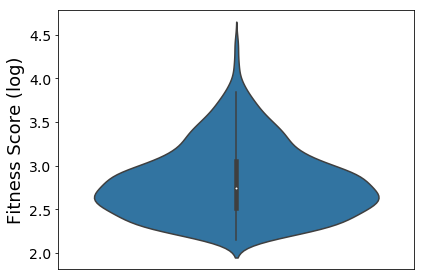

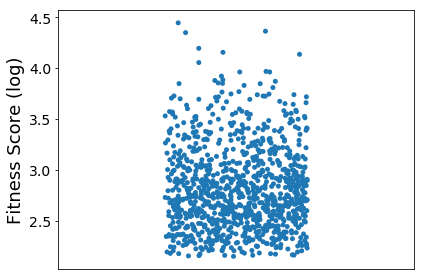

In [11]:
import seaborn as sns

save_figs = False

print("mean score = " + str(round(np.mean(score_pred), 4)))
print("std score = " + str(round(np.std(score_pred), 4)))
print("-------------------------")

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=[score_pred])

plt.xticks([], [])
plt.yticks(fontsize=14)

plt.ylabel('Fitness Score (log)', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_fitness_score_violin.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_fitness_score_violin.eps")
    plt.savefig(model_prefix + "_fitness_score_violin.svg")

plt.show()

f = plt.figure(figsize=(6, 4))

sns.stripplot(data=[score_pred], jitter=1.)

plt.xlim(-0.25, 0.25)

plt.xticks([], [])
plt.yticks(fontsize=14)

plt.ylabel('Fitness Score (log)', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_fitness_score_stripplot.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_fitness_score_stripplot.eps")
    plt.savefig(model_prefix + "_fitness_score_stripplot.svg")

plt.show()


In [12]:
#Calculate average/std nucleotide entropy

nt_entropies = []
for j in range(onehots.shape[1]) :
    if sequence_templates[0][j] == 'N' :

        p_A = np.sum(onehots[:, j, 0]) / n
        p_C = np.sum(onehots[:, j, 1]) / n
        p_G = np.sum(onehots[:, j, 2]) / n
        p_T = np.sum(onehots[:, j, 3]) / n

        nt_entropy = 0
        if p_A * p_C * p_G * p_T > 0. :
            nt_entropy = - (p_A * np.log2(p_A) + p_C * np.log2(p_C) + p_G * np.log2(p_G) + p_T * np.log2(p_T))

        nt_entropies.append(nt_entropy)

nt_entropies = np.array(nt_entropies)

print("Mean NT Entropy = " + str(round(np.mean(nt_entropies), 4)))
print("Std NT Entropy = " + str(round(np.std(nt_entropies), 4)))


#Calculate hexamer entropies

hexamer_encoder = isol.NMerEncoder(n_mer_len=6, count_n_mers=True)

hexamers = isol.SparseBatchEncoder(encoder=hexamer_encoder)([
    acgt_encoder.decode(onehots[i, :, :]) for i in range(onehots.shape[0])
])

hexamer_sum = np.ravel(hexamers.sum(axis=0))
hexamers_probs = hexamer_sum / np.sum(hexamer_sum)
n_nonzero_hexamers = len(np.nonzero(hexamer_sum > 0)[0])

print("Number of unique hexamers = " + str(n_nonzero_hexamers))

hexamer_entropy = -1. * np.sum(hexamers_probs[hexamer_sum > 0] * np.log2(hexamers_probs[hexamer_sum > 0]))

print("Hexamer Entropy = " + str(hexamer_entropy))


#Calculate average/std hexamer entropy

nonzero_index = np.nonzero(hexamer_sum > 0)[0]

hexamer_entropies = []
for j in range(n_nonzero_hexamers) :
    p_on = len(np.nonzero(hexamers[:, nonzero_index[j]] > 0)[0]) / hexamers.shape[0]
    p_off = 1. - p_on

    hexamer_entropy = 0
    if p_on * p_off > 0. :
        hexamer_entropy = -(p_on * np.log2(p_on) + p_off * np.log2(p_off))

    hexamer_entropies.append(hexamer_entropy)

hexamer_entropies = np.array(hexamer_entropies)

print("Mean Binary Hexamer Entropy = " + str(round(np.mean(hexamer_entropies), 4)))
print("Std Binary Hexamer Entropy = " + str(round(np.std(hexamer_entropies), 4)))



Mean NT Entropy = 1.9801
Std NT Entropy = 0.0162
Number of unique hexamers = 3254
Hexamer Entropy = 9.6264262759959
Mean Binary Hexamer Entropy = 0.1576
Std Binary Hexamer Entropy = 0.1999


mean distance/nt = 0.4961
std distance/nt = 0.0347
-------------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


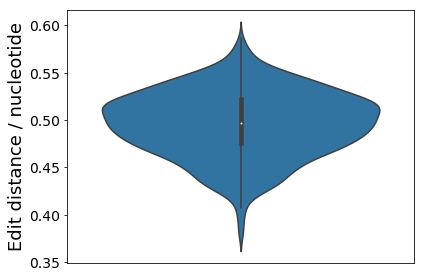

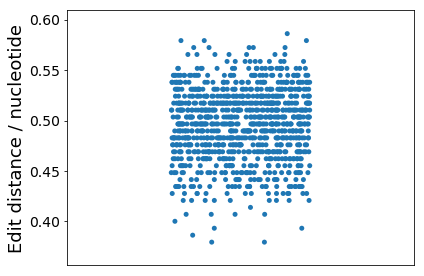

In [13]:
import editdistance

#Calculate random pair-wise edit distances

save_figs = False

seqs = [
    acgt_encoder.decode(onehots[i, :, :]) for i in range(onehots.shape[0])
]

shuffle_index = np.arange(len(seqs))
np.random.shuffle(shuffle_index)

distances = []
for i in range(len(seqs)) :
    if i == shuffle_index[i] :
        continue
    
    seq_1 = seqs[i]
    seq_2 = seqs[shuffle_index[i]]
    
    dist = editdistance.eval(seq_1, seq_2)

    distances.append(dist)

    import seaborn as sns

distances = np.array(distances) / np.sum([1 if sequence_templates[0][j] == 'N' else 0 for j in range(len(sequence_templates[0]))])

print("mean distance/nt = " + str(round(np.mean(distances), 4)))
print("std distance/nt = " + str(round(np.std(distances), 4)))
print("-------------------------")

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=[distances])

plt.xticks([], [])
plt.yticks(fontsize=14)

plt.ylabel('Edit distance / nucleotide', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_edit_distance_violin.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_edit_distance_violin.eps")
    plt.savefig(model_prefix + "_edit_distance_violin.svg")

plt.show()

f = plt.figure(figsize=(6, 4))

sns.stripplot(data=[distances], jitter=1.)

plt.xlim(-0.25, 0.25)

plt.xticks([], [])
plt.yticks(fontsize=14)

plt.ylabel('Edit distance / nucleotide', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_edit_distance_stripplot.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_edit_distance_stripplot.eps")
    plt.savefig(model_prefix + "_edit_distance_stripplot.svg")

plt.show()


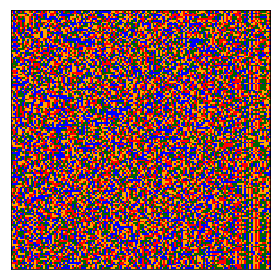

In [14]:

plot_n_seqs = 145
plot_start = 0
plot_end = 145

save_figs = False

flat_pwms = np.zeros((pwms.shape[0], pwms.shape[1]))
for i in range(pwms.shape[0]) :
    for j in range(pwms.shape[1]) :
        max_nt_ix = np.argmax(pwms[i, j, :])

        flat_pwms[i, j] = max_nt_ix + 1

flat_pwms = flat_pwms[:plot_n_seqs, plot_start:plot_end]

cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
bounds=[0, 1, 2, 3, 4, 5]
norm = colors.BoundaryNorm(bounds, cmap.N)

f = plt.figure(figsize=(4, 12))

plt.imshow(flat_pwms, aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_diversity_seqs.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_diversity_seqs.svg")
    plt.savefig(model_prefix + "_diversity_seqs.eps")

plt.show()


In [15]:
#Get latent space predictor
saved_predictor_w_dense = Model(
    inputs = saved_predictor.inputs,
    outputs = saved_predictor.outputs + [saved_predictor.get_layer('dragonn_dense_1_copy').output]
)
saved_predictor_w_dense.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))


In [16]:
#Load GENESIS models and predict sample sequences

batch_size = 64

n = 4096
n_slack = 0

n_ceil = int((n + n_slack) / batch_size) * batch_size
if n_ceil < n :
    n_ceil += batch_size

sequence_class = np.array([0] * n_ceil).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.random.uniform(-1, 1, (n_ceil, 100))
noise_2 = np.random.uniform(-1, 1, (n_ceil, 100))

pred_outputs = generator.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _ = pred_outputs

pwms = optimized_pwm[:, :, :, 0]
onehots = sampled_pwm[:, 0, :, :, 0]

#Make predictions using black box model

score_pred, dense_pred = saved_predictor_w_dense.predict(x=[onehots], batch_size=batch_size)

score_pred = np.ravel(score_pred[:, 5])

sort_index = np.argsort(score_pred)[::-1]

pwms = pwms[sort_index][:n]
onehots = onehots[sort_index][:n]
score_pred = score_pred[sort_index][:n]
dense_pred = dense_pred[sort_index][:n]


In [17]:
#Save sequences to file
with open(model_prefix + "_4096_sequences.txt", "wt") as f:
    for i in range(onehots.shape[0]) :
        seq = acgt_encoder.decode(onehots[i])
        
        f.write(seq + "\n")
